# Problem Understanding

The objective of this notebook is to predict whether water is potable or not depending on specific water characteristics. It is part of a series of notebooks, where different Machine Learning models are explained and applied.

Other topics are 

* [Linear Regression](https://www.kaggle.com/code/pumalin/linear-regression-tutorial)
* [Logistic Regression](https://www.kaggle.com/code/pumalin/logistic-regression-tutorial)
* [Decision Trees](https://www.kaggle.com/code/pumalin/decision-trees-tutorial)
* [Random Forests](https://www.kaggle.com/code/pumalin/random-forest-tutorial)
* [AdaBoost](https://www.kaggle.com/code/pumalin/adaboost-tutorial)
* [GradientBoosting](https://www.kaggle.com/code/pumalin/gradient-boosting-tutorial)
* [LightGBM](https://www.kaggle.com/code/pumalin/lightgbm-tutorial)
* [CatBoost](https://www.kaggle.com/code/pumalin/catboost-tutorial)
* [Kmenas](https://www.kaggle.com/code/pumalin/kmeans-tutorial)

**This notebook does not focus on finding the best model, but on an example how to train an XGBoost.**

## Introduction

[XGBoost](https://xgboost.readthedocs.io/en/stable/) stands for eXtreme Gradient Boosting and is an implementation of the Gradient Boosting algorithm, focussing on optimizing computation speed and model performance. It can be used as a separated library, but also an integration in sklearn exists. In this notebook we will use the integration into [sklearn](https://scikit-learn.org/stable/). The XGBoosts algorithm is capable to handle large and complex datasets.

**Find more about XGBoost and other Machine Learning and Data Science articles on [datamapu](https://datamapu.com/posts/classical_ml/gradient_boosting_variants/)**

# Setup

In this section all libraries needed to run this notebook are imported.

In [1]:
# packages for data processing
import pandas as pd
import numpy as np

# packages for modelling
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils.fixes import loguniform
import xgboost as xgb

# packages for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# set random seed
SEED = 42

# Read Data

Read the data into a pandas dataframe and plot the first rows.

In [2]:
df_water = pd.read_csv("/kaggle/input/water-potability/water_potability.csv")
df_water.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


The dataset is described as follows:

|variable| information|
|--------|------------|
| pH value | PH is an important parameter in evaluating the acid–base balance of water. It is also the indicator of acidic or alkaline condition of water status. WHO has recommended maximum permissible limit of pH from 6.5 to 8.5. The current investigation ranges were 6.52–6.83 which are in the range of WHO standards.|
| Hardness | Hardness is mainly caused by calcium and magnesium salts. These salts are dissolved from geologic deposits through which water travels. The length of time water is in contact with hardness producing material helps determine how much hardness there is in raw water. Hardness was originally defined as the capacity of water to precipitate soap caused by Calcium and Magnesium. |
| Solids (Total dissolved solids - TDS)|  Water has the ability to dissolve a wide range of inorganic and some organic minerals or salts such as potassium, calcium, sodium, bicarbonates, chlorides, magnesium, sulfates etc. These minerals produced un-wanted taste and diluted color in appearance of water. This is the important parameter for the use of water. The water with high TDS value indicates that water is highly mineralized. Desirable limit for TDS is 500 mg/l and maximum limit is 1000 mg/l which prescribed for drinking purpose.|
| Chloramines | Chlorine and chloramine are the major disinfectants used in public water systems. Chloramines are most commonly formed when ammonia is added to chlorine to treat drinking water. Chlorine levels up to 4 milligrams per liter (mg/L or 4 parts per million (ppm)) are considered safe in drinking water.|
| Sulfate| Sulfates are naturally occurring substances that are found in minerals, soil, and rocks. They are present in ambient air, groundwater, plants, and food. The principal commercial use of sulfate is in the chemical industry. Sulfate concentration in seawater is about 2,700 milligrams per liter (mg/L). It ranges from 3 to 30 mg/L in most freshwater supplies, although much higher concentrations (1000 mg/L) are found in some geographic locations.|
| Conductivity| Pure water is not a good conductor of electric current rather’s a good insulator. Increase in ions concentration enhances the electrical conductivity of water. Generally, the amount of dissolved solids in water determines the electrical conductivity. Electrical conductivity (EC) actually measures the ionic process of a solution that enables it to transmit current. According to WHO standards, EC value should not exceeded 400 μS/cm.|
| Organic_carbon | Total Organic Carbon (TOC) in source waters comes from decaying natural organic matter (NOM) as well as synthetic sources. TOC is a measure of the total amount of carbon in organic compounds in pure water. According to US EPA < 2 mg/L as TOC in treated / drinking water, and < 4 mg/Lit in source water which is use for treatment.|
| Trihalomethanes | THMs are chemicals which may be found in water treated with chlorine. The concentration of THMs in drinking water varies according to the level of organic material in the water, the amount of chlorine required to treat the water, and the temperature of the water that is being treated. THM levels up to 80 ppm is considered safe in drinking water.|
| Turbidity | The turbidity of water depends on the quantity of solid matter present in the suspended state. It is a measure of light emitting properties of water and the test is used to indicate the quality of waste discharge with respect to colloidal matter. The mean turbidity value obtained for Wondo Genet Campus (0.98 NTU) is lower than the WHO recommended value of 5.00 NTU.|
| Potability | Indicates if water is safe for human consumption where 1 means Potable and 0 means Not potable. (TARGET)|

# Data Exploration

Explore the dataframe, the possible features and the target variable.


Check all columns and their types.

In [3]:
df_water.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


**Observations**
* In total the dataframe has 3276 rows
* ph, Sulfate, and Trihalomethanes have missing values
* There are 9 possible input feature and one target variable, which is 'Potability'
* The target variable 'Potability' is of type integer, all the others are of type float, i.e. we don't need to convert any types

**Note**, that we don't need to remove the **missing values**, because XGBoost natively supports the treatment of missing values.
The [documentation](https://xgboost.readthedocreadthedocsreadthedocss.io/en/stable/faq.html) gives the following explanation:

"XGBoost supports missing values by default. In tree algorithms, branch directions for missing values are learned during training. Note that the gblinear booster treats missing values as zeros.
When the missing parameter is specified, values in the input predictor that is equal to missing will be treated as missing and removed. By default it’s set to NaN."

Show basic statistics of all columns

In [4]:
df_water.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


**Observations**
* Input feaures vary in their range
* The target variable is binary

Plot data distributions

In [5]:
def distplots(df=df_water,n=8):
    cols = list(df.columns)
    fig, axes = plt.subplots(5, 2, figsize=(15,8))
    plt.tight_layout(pad=3)
    for col, ax in enumerate(axes.flatten()):
        if df[cols[col]].dtypes=='float64':
            sns.boxplot(x=df[cols[col]], ax=ax, color='darkcyan')
        if col>n:
            break;

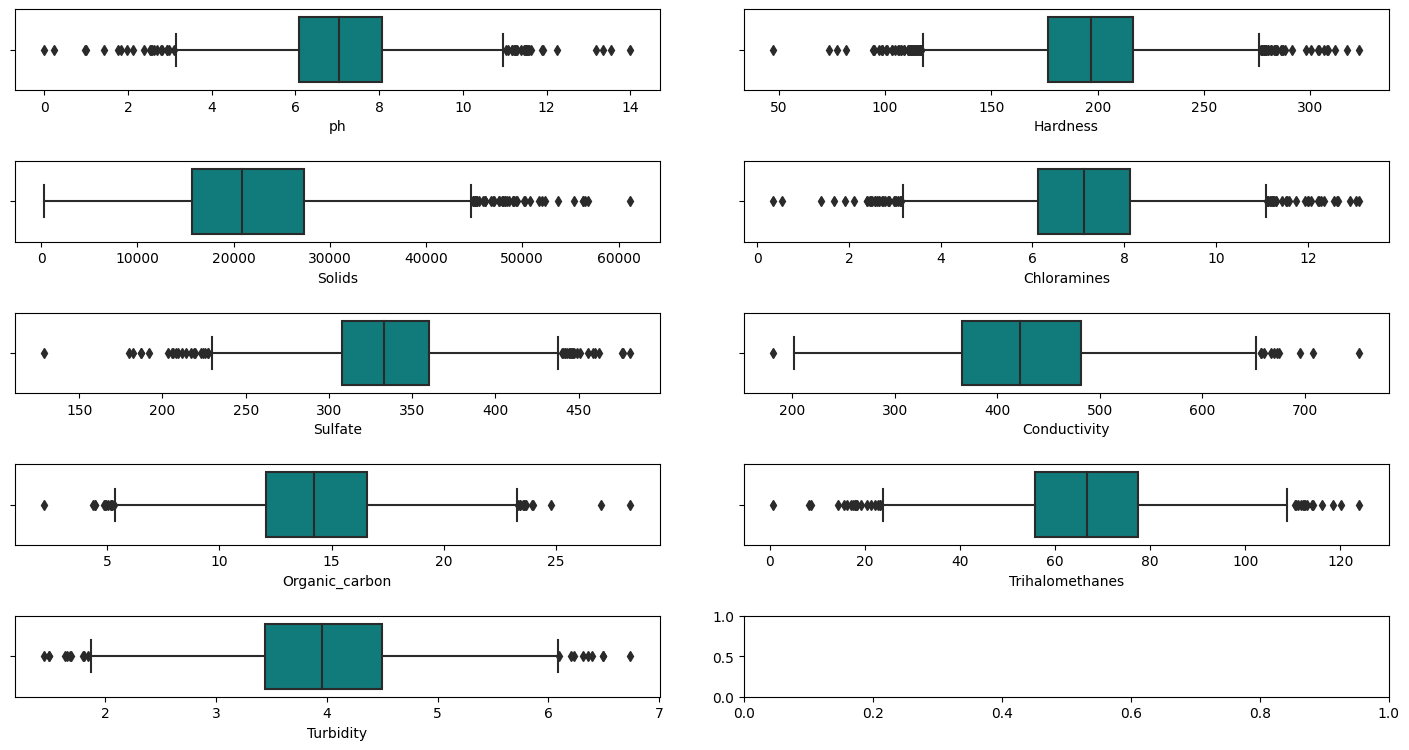

In [6]:
distplots(df=df_water)

In [7]:
df_water['Potability'].value_counts()

Potability
0    1998
1    1278
Name: count, dtype: int64

**Observations**
* There are no extreme outliers
* Most of the input feature are normally distributed
* 'Solids' and 'Conductivity' seem to be right-skewed (no statistical test done here, only from visual inspection)
* The target variable is not equally distributed, but their are more samples with a negative target class than a positive

# Data Preparation

Split the data into training, validation and test set. 

In [8]:
# train - validation split
df_train_full, df_test = train_test_split(df_water, test_size=0.2, shuffle=True, random_state=SEED)
df_train, df_valid = train_test_split(df_train_full, test_size=0.25, shuffle=True, random_state=SEED)
print(f'train data shape: X - {df_train.shape}, y - {df_train["Potability"].shape}')
print(f'validation data shape: X - {df_valid.shape}, y - {df_valid["Potability"].shape}')
print(f'test data shape: X - {df_test.shape}, y - {df_test["Potability"].shape}')

train data shape: X - (1965, 10), y - (1965,)
validation data shape: X - (655, 10), y - (655,)
test data shape: X - (656, 10), y - (656,)


We equalize the two target classes. If we don't do this, the majority class will dominate the model. There are different options
1. Downsanḿpling. Draw randomly the number of samples of the minority class from the majority class. This leads to a loss of data.
2. Upsampling.
​
    a) Randomly draw samples from the minority class until the number of the ajority class is achieved. This leads o dubplicate samples in the dataset and can lead to overfitting.
    
    b) Create artificial data using e.g. [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) from the minority class until the number of samples of the majority class is achieved.


For this example we will use option 1 for simplicity. Note that if upsampling is done, this is done for the training data only. Otherwise data leakage may occur, that is we may use data for training that is also in tha validation or test set.

In [9]:
df_majority = df_train[df_train.Potability==0]
df_minority = df_train[df_train.Potability==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
df_upsampled.Potability.value_counts()

Potability
0    1189
1    1189
Name: count, dtype: int64

# Modelling

Set features and target values of train, validation, and test set.


In [10]:
features = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']

X_train = df_train[features]
X_valid = df_valid[features]
X_test = df_test[features]

y_train = df_train['Potability']
y_valid = df_valid['Potability']
y_test = df_test['Potability']

We set the parameters to train the model. First, we will use fixed values and train two models. The parameters here are the same as the default values, so actually we wouldn´t need to set them, but we'll set them for two reasons. First, to see how the parameters are set. The second reason is that we are later going to do hyperparameter tuning with the same parameters. The purpose of training these two models is to see the advantages of the early stopping option. The first model trains without and the second with early stopping. To use early stopping an evaluation set needs to be set an evaluation set. This is to see the advantage of early stopping.

* "eta": 0.3,
* "gamma": 0,
* "max_depth": 6,
* "lambda": 1,
* "alpha": 0,
* "booster": "gbtree",
* "verbosity": 2,
* "early_stopping_rounds": 10 (just for the second model)
    
 

Training without early stopping.

In [11]:
parameters = {
    "n_estimators": 500,
    "eta": 0.3,
    "gamma": 0,
    "max_depth": 6,
    "lambda": 1,
    "alpha": 0,
    "booster": "gbtree",
    "verbosity": 2,
    
}

model_full = xgb.XGBClassifier(**parameters)
model_full.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

[0]	validation_0-logloss:0.66049
[1]	validation_0-logloss:0.64852
[2]	validation_0-logloss:0.64966
[3]	validation_0-logloss:0.64675
[4]	validation_0-logloss:0.64216
[5]	validation_0-logloss:0.64282
[6]	validation_0-logloss:0.64312
[7]	validation_0-logloss:0.64223
[8]	validation_0-logloss:0.64086
[9]	validation_0-logloss:0.64327
[10]	validation_0-logloss:0.65755
[11]	validation_0-logloss:0.65741
[12]	validation_0-logloss:0.65721
[13]	validation_0-logloss:0.65679
[14]	validation_0-logloss:0.65901
[15]	validation_0-logloss:0.66005
[16]	validation_0-logloss:0.66253
[17]	validation_0-logloss:0.66405
[18]	validation_0-logloss:0.66571
[19]	validation_0-logloss:0.67038
[20]	validation_0-logloss:0.67034
[21]	validation_0-logloss:0.67474
[22]	validation_0-logloss:0.68102
[23]	validation_0-logloss:0.67774
[24]	validation_0-logloss:0.67879
[25]	validation_0-logloss:0.68161
[26]	validation_0-logloss:0.68678
[27]	validation_0-logloss:0.69155
[28]	validation_0-logloss:0.69633
[29]	validation_0-loglos

XGBClassifier(alpha=0, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500, ...)

Training with early stopping.

In [12]:
model_es = xgb.XGBClassifier(**parameters, early_stopping_rounds = 20)
model_es.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

[0]	validation_0-logloss:0.66049
[1]	validation_0-logloss:0.64852
[2]	validation_0-logloss:0.64966
[3]	validation_0-logloss:0.64675
[4]	validation_0-logloss:0.64216
[5]	validation_0-logloss:0.64282
[6]	validation_0-logloss:0.64312
[7]	validation_0-logloss:0.64223
[8]	validation_0-logloss:0.64086
[9]	validation_0-logloss:0.64327
[10]	validation_0-logloss:0.65755
[11]	validation_0-logloss:0.65741
[12]	validation_0-logloss:0.65721
[13]	validation_0-logloss:0.65679
[14]	validation_0-logloss:0.65901
[15]	validation_0-logloss:0.66005
[16]	validation_0-logloss:0.66253
[17]	validation_0-logloss:0.66405
[18]	validation_0-logloss:0.66571
[19]	validation_0-logloss:0.67038
[20]	validation_0-logloss:0.67034
[21]	validation_0-logloss:0.67474
[22]	validation_0-logloss:0.68102
[23]	validation_0-logloss:0.67774
[24]	validation_0-logloss:0.67879
[25]	validation_0-logloss:0.68161
[26]	validation_0-logloss:0.68678
[27]	validation_0-logloss:0.69155


XGBClassifier(alpha=0, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=20,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500, ...)

Plot the resulting losses of the two models.

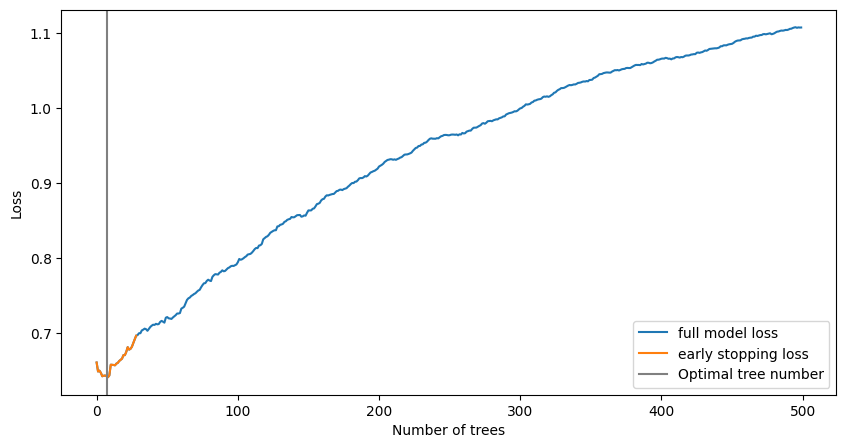

In [13]:
results_full = model_full.evals_result()
results_es = model_es.evals_result()

plt.figure(figsize=(10,5))
plt.plot(results_full["validation_0"]["logloss"], label="full model loss")
plt.plot(results_es["validation_0"]["logloss"], label="early stopping loss")
plt.axvline(7, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend();

The previous plot shows that the loss (RMSE) is only falling for the first 7 iterations. Then the loss starts to increase. Using early stopping reduces the training time, because the model stops if the model does not improve. Additionally the model with the lowest loss is saved and not the latest one. 

**Evaluation**

We calculate Accuracy, Recall, and Precision for the three data splits for both models.

Full model

In [14]:
print("training:")
y_train_pred = model_full.predict(X_train)
print(f"Accuracy: {accuracy_score(y_train_pred, y_train):.3f}, Recall: {recall_score(y_train_pred, y_train):.3f}, Precision: {precision_score(y_train_pred, y_train):.3f}")
print("\nvalidation:")
y_valid_pred = model_full.predict(X_valid)
print(f"Accuracy: {accuracy_score(y_valid_pred, y_valid):.3f}, Recall: {recall_score(y_valid_pred, y_valid):.3f}, Precision: {precision_score(y_valid_pred, y_valid):.3f}")
print("\ntest:")
y_test_pred = model_full.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test_pred, y_test):.3f}, Recall: {recall_score(y_test_pred, y_test):.3f}, Precision: {precision_score(y_test_pred, y_test):.3f}")

training:
Accuracy: 1.000, Recall: 1.000, Precision: 1.000

validation:
Accuracy: 0.624, Recall: 0.529, Precision: 0.430

test:
Accuracy: 0.639, Recall: 0.518, Precision: 0.414


Model with early stopping

In [15]:
print("training:")
y_train_pred = model_es.predict(X_train)
print(f"Accuracy: {accuracy_score(y_train_pred, y_train):.3f}, Recall: {recall_score(y_train_pred, y_train):.3f}, Precision: {precision_score(y_train_pred, y_train):.3f}")
print("\nvalidation:")
y_valid_pred = model_es.predict(X_valid)
print(f"Accuracy: {accuracy_score(y_valid_pred, y_valid):.3f}, Recall: {recall_score(y_valid_pred, y_valid):.3f}, Precision: {precision_score(y_valid_pred, y_valid):.3f}")
print("\ntest:")
y_test_pred = model_es.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test_pred, y_test):.3f}, Recall: {recall_score(y_test_pred, y_test):.3f}, Precision: {precision_score(y_test_pred, y_test):.3f}")

training:
Accuracy: 0.802, Recall: 0.907, Precision: 0.555

validation:
Accuracy: 0.641, Recall: 0.589, Precision: 0.295

test:
Accuracy: 0.666, Recall: 0.597, Precision: 0.316


**Observations**

The model without early stopping is clearly overfitting. Using early stopping improves this, but also this model is still overfitting. Both models show low precision values.

### Hyperparameter Tuning

We will now use hyperparameter tuning to see if the model can be improved.


In [16]:
param_grid = {
    "n_estimators": [5, 10, 15, 20, 50],
    "eta": [1e-1, 1e-2, 3e-1], 
    "gamma": [0.1, 1],
    "max_depth": [4, 6, 8],
    "lambda": [0.1, 1],
    "alpha": [0,0.1,1],
    "verbosity": [0]
}

xgb_model = xgb.XGBClassifier()

grid_search = GridSearchCV(
    estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1)
 

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'alpha': [0, 0.1, 1], 'eta': [0.1, 0.01, 0.3],
                         'gamma': [0.1, 1], 'lambda': [0.1, 1],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [5, 10, 15, 20, 50],
                         'verbosity': [0]})

We will use these best model parameters and additionally early stopping and fit a model to these parameters.

In [17]:
parameters = grid_search.best_params_
parameters["early_stopping_rounds"] = 10
parameters

{'alpha': 1,
 'eta': 0.1,
 'gamma': 1,
 'lambda': 1,
 'max_depth': 4,
 'n_estimators': 50,
 'verbosity': 0,
 'early_stopping_rounds': 10}

In [18]:
model_hp = xgb.XGBClassifier(**parameters)
model_hp.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
results = model_hp.evals_result()



[0]	validation_0-logloss:0.66821
[1]	validation_0-logloss:0.66616
[2]	validation_0-logloss:0.66466
[3]	validation_0-logloss:0.66209
[4]	validation_0-logloss:0.65956
[5]	validation_0-logloss:0.65759
[6]	validation_0-logloss:0.65666
[7]	validation_0-logloss:0.65434
[8]	validation_0-logloss:0.65276
[9]	validation_0-logloss:0.65132
[10]	validation_0-logloss:0.64961
[11]	validation_0-logloss:0.64940
[12]	validation_0-logloss:0.64888
[13]	validation_0-logloss:0.64596
[14]	validation_0-logloss:0.64649
[15]	validation_0-logloss:0.64469
[16]	validation_0-logloss:0.64357
[17]	validation_0-logloss:0.64296
[18]	validation_0-logloss:0.64340
[19]	validation_0-logloss:0.64289
[20]	validation_0-logloss:0.64259
[21]	validation_0-logloss:0.64174
[22]	validation_0-logloss:0.64217
[23]	validation_0-logloss:0.64259
[24]	validation_0-logloss:0.64300
[25]	validation_0-logloss:0.64366
[26]	validation_0-logloss:0.64332
[27]	validation_0-logloss:0.64334
[28]	validation_0-logloss:0.64302
[29]	validation_0-loglos

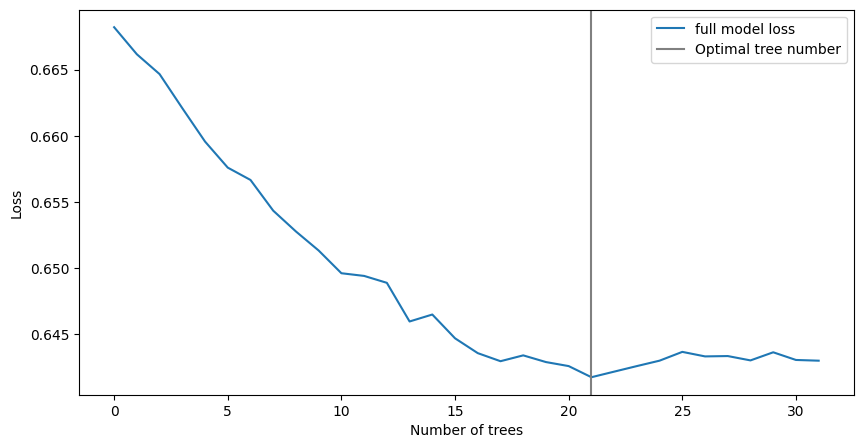

In [19]:
plt.figure(figsize=(10,5))
plt.plot(results["validation_0"]["logloss"], label="full model loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend();

**Evaluation**

We calculate Accuracy, Recall, and Precision for the three data splits using the tuned model.

In [20]:
print("training:")
y_train_pred = model_hp.predict(X_train)
print(f"Accuracy: {accuracy_score(y_train_pred, y_train):.3f}, Recall: {recall_score(y_train_pred, y_train):.3f}, Precision: {precision_score(y_train_pred, y_train):.3f}")
print("\nvalidation:")
y_valid_pred = model_hp.predict(X_valid)
print(f"Accuracy: {accuracy_score(y_valid_pred, y_valid):.3f}, Recall: {recall_score(y_valid_pred, y_valid):.3f}, Precision: {precision_score(y_valid_pred, y_valid):.3f}")
print("\ntest:")
y_test_pred = model_hp.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test_pred, y_test):.3f}, Recall: {recall_score(y_test_pred, y_test):.3f}, Precision: {precision_score(y_test_pred, y_test):.3f}")

training:
Accuracy: 0.715, Recall: 0.853, Precision: 0.336

validation:
Accuracy: 0.650, Recall: 0.679, Precision: 0.213

test:
Accuracy: 0.669, Recall: 0.667, Precision: 0.221


**Observations**

We see that only a little bit of tuning improved the results. The validation metrics are a bit improved and the overfitting is reduced. We didn´t spend many time on the hyperparameter tuning, further fine tuning may improve the model further.

**Footnote**

Find more about Data Science and Machine Learning [here](https://datamapu.com/)